## Data Preparation and Transformation

The code in this section is responsible for loading, processing, and transforming the data sets for USDT, USDC, and DAI. It includes functions for reading the transaction data, filtering out exchange-related transactions, and aggregating the data for analysis. 

**Note to readers:** If you're here for the analysis insights, feel free to skip to the **Analysis Section**.


In [38]:
import pandas as pd
cex = pd.read_csv('./cex.csv')
USDC = 'USDC'
USDT = 'USDT'
DAI = 'DAI'

def load_files(stablecoin_name: str):
    # Merge datasets
    df = pd.DataFrame()
    for month in range(1, 11): #until 11 for October'23
        file_name = f'{stablecoin_name}_2023.{month:02d}-.csv'
        current_df = pd.read_csv(f'../data/2023/{stablecoin_name}/{file_name}')
        df = pd.concat([df, current_df], ignore_index=True)
    print(f'✅ {stablecoin_name} files successfully loaded.')
    return df

def transform_data(df, stablecoin_name: str):
    # Include only txns where `to` is a CEX
    mask = df['to'].isin(cex['address'])
    df_nodex = df[mask]
    
    # Filter for retail transactions (value between 1 and 10000)
    retail_mask = df_nodex['value'].between(1, 10000)
    df_retail = df_nodex[retail_mask]

    # Group by 'date' and perform the aggregations
    agg_df = df_nodex.groupby('date')['value'].agg(['sum']).reset_index()
    retail_agg_df = df_retail.groupby('date')['value'].agg(['sum']).reset_index()

    # Count unique 'from' addresses
    wallets = df_nodex.groupby('date')['from'].nunique().rename('total_wallets')
    retail_wallets = df_retail.groupby('date')['from'].nunique().rename('retail_wallets')

    # Merge the aggregated data with the unique wallets count
    df_merged = pd.merge(wallets, agg_df, on='date', how='left')
    df_merged = pd.merge(df_merged, retail_wallets, on='date', how='left')
    df_merged = pd.merge(df_merged, retail_agg_df, on='date', how='left', suffixes=('', '_retail'))

    # Rename columns
    df_merged.rename(columns={'sum': 'total_vol', 'sum_retail': 'retail_vol'}, inplace=True)

    # Add asset type
    df_merged['asset'] = stablecoin_name

    # Format 'wallets' and 'retail_wallets' column with thousands comma
    df_merged['total_wallets'] = df_merged['total_wallets'].apply(lambda x: f"{x:,}")
    df_merged['retail_wallets'] = df_merged['retail_wallets'].apply(lambda x: f"{x:,}")

    # Format 'sum' and 'sum_retail' to two decimals in billions
    df_merged['total_vol'] = df_merged['total_vol'].apply(lambda x: f"{x / 1_000_000_000:,.1f}b")
    df_merged['retail_vol'] = df_merged['retail_vol'].apply(lambda x: f"{x / 1_000_000_000:,.1f}b")

    # Format the date as 'YYYY-MM'
    df_merged['date'] = pd.to_datetime(df_merged['date']).dt.to_period('M')

    return df_merged

In [39]:
# Load data
df_usdt = load_files(USDT)
df_usdc = load_files(USDC)
df_dai = load_files(DAI)

✅ USDT files successfully loaded.
✅ USDC files successfully loaded.
✅ DAI files successfully loaded.


In [40]:
# Transform data
df_usdt_unique = transform_data(df_usdt, USDT)
df_usdc_unique = transform_data(df_usdc, USDC)
df_dai_unique = transform_data(df_dai, DAI)

In [41]:
# Define the charts
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
%matplotlib inline
sns.set_theme(style="darkgrid")

# Concatenate and load the DataFrames
combined_df = pd.concat([df_usdt_unique, df_usdc_unique, df_dai_unique])

# If 'date' is of PeriodDtype, convert to Timestamp; else,  convert it to datetime
if isinstance(combined_df['date'].dtype, pd.PeriodDtype):
    combined_df['date'] = combined_df['date'].dt.to_timestamp()
elif not pd.api.types.is_datetime64_any_dtype(combined_df['date']):
    combined_df['date'] = pd.to_datetime(combined_df['date'])

# Remove commas and convert to integer
combined_df['total_wallets'] = combined_df['total_wallets'].str.replace(',', '').astype(int)
combined_df['total_vol'] = combined_df['total_vol'].str.replace('b', '').str.replace(',', '').astype(float) * 1_000_000_000


def show_lineplot_wallets():
    # Plot the line graph
    sns.lineplot(data=combined_df, x='date', y='total_wallets', hue='asset')

    plt.title('Total Wallets Over Time by Stablecoin')
    plt.xlabel('Period')
    plt.ylabel('Total Wallets')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 1e-3:.0f}K')) # in thousands
    plt.xticks(rotation=45)  # Rotate the x-axis labels if needed
    plt.show()

def show_lineplot_volume():
    # Plot the line graph
    sns.lineplot(data=combined_df, x='date', y='total_vol', hue='asset')

    plt.title('Total Volume Over Time by Stablecoin')
    plt.xlabel('Period')
    plt.ylabel('Total Volume')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1e9:.0f}b'))
    plt.xticks(rotation=45)  # Rotate the x-axis labels if needed
    plt.show()

<a id="analysis-section"></a>
## Stablecoin Transaction Analysis: Volume and Wallet Count

### Analysis Objective

The primary goal of this analysis is to estimate the monthly active users of stablecoins, serving as a proxy for the engagement in the Decentralized Finance (DeFi) space.


### Methodological Considerations:

- The wallet count is derived from `sender` addresses involved in Transfer events for USDT, USDC, or DAI.
- Each wallet is counted only once per month, regardless of the number of transactions it participates in.
- Retail accounts and transaction volumes are identified based on transfers that involve assets valued between 1 and 10,000 units.
- Only Centralized Exchange (CEX) wallets are included in the count through deposits into identified CEX proxy addresses.
- Any other transaction, such as transfers between EOAs, to DEXes or withdrawals from CEXes, are excluded from this analysis.

### USDT Transfer Analysis

In [42]:
print(f'\nAmount of USDT transfers: {len(df_usdt.index):,}')
print(f'Average unique total wallets: {df_usdt_unique['total_wallets'].str.replace(',', '').astype(int).mean():,}')
print(f'Unique total wallets and volume:\n\n{df_usdt_unique.to_string(index=False)}')


Amount of USDT transfers: 41,083,882
Average unique total wallets: 295,833.9
Unique total wallets and volume:

   date total_wallets total_vol retail_wallets retail_vol asset
2023-01       291,584     32.5b        259,696       0.7b  USDT
2023-02       333,103     26.2b        304,226       0.7b  USDT
2023-03       342,053     49.7b        304,612       0.8b  USDT
2023-04       279,199     26.9b        247,682       0.7b  USDT
2023-05       258,309     24.4b        229,394       0.6b  USDT
2023-06       357,983     32.5b        324,673       0.7b  USDT
2023-07       238,496     21.7b        211,806       0.6b  USDT
2023-08       272,363     28.5b        244,647       0.6b  USDT
2023-09       251,434     20.2b        225,332       0.6b  USDT
2023-10       333,815     27.6b        302,775       0.7b  USDT


### USDC Transfer Analysis

In [43]:
print(f'\nAmount of USDC transfers: {len(df_usdc.index):,}')
print(f'Average unique total wallets: {df_usdc_unique['total_wallets'].str.replace(',', '').astype(int).mean():,}')
print(f'Unique total wallets and volume:\n\n{df_usdc_unique.to_string(index=False)}')


Amount of USDC transfers: 18,474,834
Average unique total wallets: 97,688.0
Unique total wallets and volume:

   date total_wallets total_vol retail_wallets retail_vol asset
2023-01       117,799     54.5b        101,199       0.3b  USDC
2023-02        90,507     37.4b         74,367       0.3b  USDC
2023-03       120,636     57.5b         94,071       0.3b  USDC
2023-04        76,967     16.7b         63,114       0.2b  USDC
2023-05        91,507     14.7b         79,140       0.2b  USDC
2023-06       128,722     18.1b        114,315       0.2b  USDC
2023-07       117,774     17.0b        105,014       0.2b  USDC
2023-08        74,657     18.6b         63,116       0.2b  USDC
2023-09        68,390     13.7b         57,547       0.2b  USDC
2023-10        89,921     18.2b         76,825       0.2b  USDC


### DAI Transfer Analysis

In [44]:
print(f'\nAmount of DAI transfers: {len(df_dai.index):,}')
print(f'Average unique total wallets: {df_dai_unique['total_wallets'].str.replace(',', '').astype(int).mean():,}')
print(f'Unique total wallets and volume:\n\n{df_dai_unique.to_string(index=False)}')


Amount of DAI transfers: 2,201,031
Average unique total wallets: 9,726.1
Unique total wallets and volume:

   date total_wallets total_vol retail_wallets retail_vol asset
2023-01         8,378      0.4b          6,904       0.0b   DAI
2023-02        15,808      0.4b         14,568       0.0b   DAI
2023-03        13,037      1.3b         10,637       0.0b   DAI
2023-04         6,776      0.4b          5,653       0.0b   DAI
2023-05         6,007      0.2b          4,887       0.0b   DAI
2023-06        23,917      0.2b         22,782       0.0b   DAI
2023-07         6,179      0.2b          5,268       0.0b   DAI
2023-08         6,227      0.3b          5,033       0.0b   DAI
2023-09         5,430      0.2b          4,665       0.0b   DAI
2023-10         5,502      0.3b          4,609       0.0b   DAI


## Stablecoin Usage Trends

This section visualizes the trends in stablecoin usage over time. The charts below break down the total number of wallets and the total volume of transactions for USDT, USDC, and DAI, providing insights into the adoption rates and transactional throughput of these stablecoins.


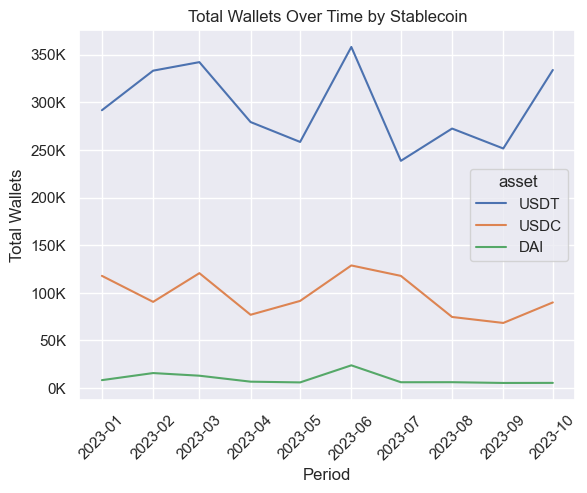

In [45]:
show_lineplot_wallets()

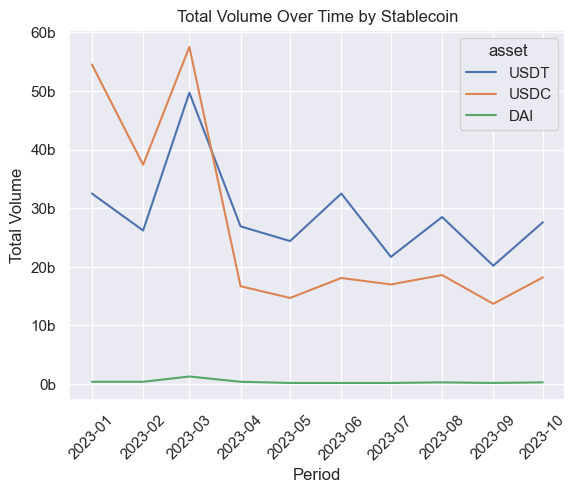

In [46]:
show_lineplot_volume()